Loading target stock: iba...
Loading first 500 ETFs for comparison...
Calculating correlations...

--- RESULTS ---
Target Stock: iba
Most Correlated ETF: pplt
Correlation Score: 0.9996


/var/folders/31/3_syjrfx3y37_81q3x4ldg200000gn/T/ipykernel_26001/38815275.py:49: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_returns = combined_df.pct_change().dropna()
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


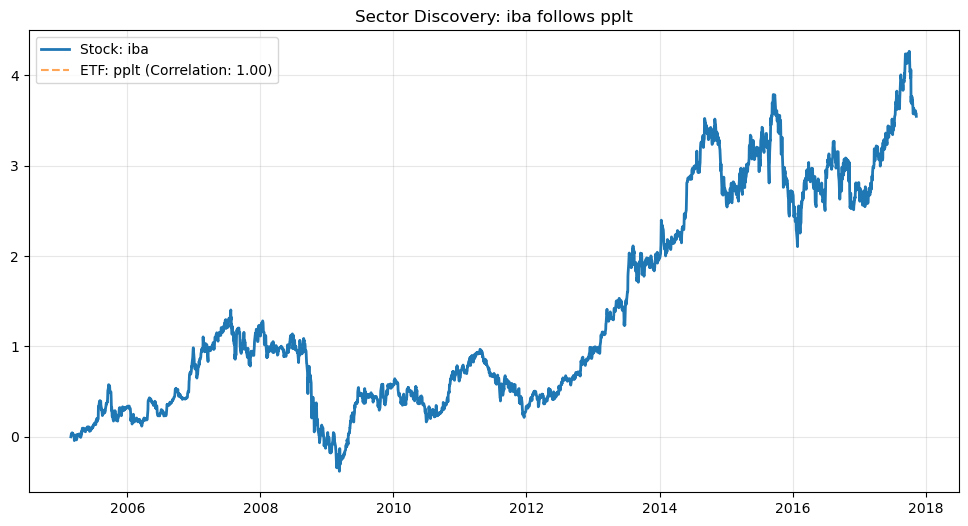

In [ ]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
STOCK_NAME = 'iba'  # The stock from your screenshot
DATA_PATH_STOCKS = '../data/Stocks'
DATA_PATH_ETFS = '../data/ETFs'
NUM_ETFS_TO_CHECK = 500  # Limit to 500 to keep it fast for now

# --- HELPER FUNCTIONS ---
def load_single_file(path):
    df = pd.read_csv(path)
    # Standardize column names
    df.columns = [c.lower() for c in df.columns]
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df['close'] # We only care about Close price for correlation

# 1. Load the Target Stock
print(f"Loading target stock: {STOCK_NAME}...")
stock_path = os.path.join(DATA_PATH_STOCKS, f"{STOCK_NAME}.us.txt")
stock_series = load_single_file(stock_path)

# 2. Load a Batch of ETFs
print(f"Loading first {NUM_ETFS_TO_CHECK} ETFs for comparison...")
etf_files = glob.glob(os.path.join(DATA_PATH_ETFS, "*.txt"))[:NUM_ETFS_TO_CHECK]
etf_data = {}

for f in etf_files:
    name = os.path.basename(f).split('.')[0]
    try:
        etf_data[name] = load_single_file(f)
    except Exception as e:
        print(f"Skipping {name}: {e}")

# Convert dictionary to DataFrame (aligns dates automatically)
etf_df = pd.DataFrame(etf_data)

# 3. Data Alignment & Cleaning
# We join the stock with the ETFs on the Date index
# 'inner' join keeps only dates where we have data for BOTH
combined_df = etf_df.join(stock_series.rename(STOCK_NAME), how='inner')

# OPTIONAL: Use Percentage Change instead of Raw Price
# (Critical: A $10 stock and $1000 ETF correlate better on % change)
combined_returns = combined_df.pct_change().dropna()

# 4. Calculate Correlation
print("Calculating correlations...")
# Calculate correlation of every column against the 'stock' column
correlations = combined_returns.corrwith(combined_returns[STOCK_NAME])

# Sort to find the best match
sorted_corr = correlations.abs().sort_values(ascending=False)

# Drop the stock itself (correlation 1.0) and get top match
top_match_name = sorted_corr.index[1] 
top_match_score = sorted_corr.iloc[1]

print(f"\n--- RESULTS ---")
print(f"Target Stock: {STOCK_NAME}")
print(f"Most Correlated ETF: {top_match_name}")
print(f"Correlation Score: {top_match_score:.4f}")

# 5. Visual Proof (The "Money Shot" for your project report)
# We plot normalized prices to compare the TREND
plt.figure(figsize=(12, 6))

# Normalize to start at 0 for easy comparison
norm_stock = (combined_df[STOCK_NAME] - combined_df[STOCK_NAME].iloc[0]) / combined_df[STOCK_NAME].iloc[0]
norm_etf = (combined_df[top_match_name] - combined_df[top_match_name].iloc[0]) / combined_df[top_match_name].iloc[0]

plt.plot(norm_stock, label=f'Stock: {STOCK_NAME}', linewidth=2)
plt.plot(norm_etf, label=f'ETF: {top_match_name} (Correlation: {top_match_score:.2f})', linestyle='--', alpha=0.7)

plt.title(f"Sector Discovery: {STOCK_NAME} follows {top_match_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()